# FASE 2: Voorspellen elektrisch verbruik warmtepomp

* kWh per tijdbasis 15m
* Household 1 gebruikt voor data (JVR)
* datetime features
   * stookseizoen
   * dag
   * uur

In [41]:
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True)

from prophet import Prophet

## Data-analyse
### Inlezen en voorbereiden van data

In [42]:
# Open de datasets
df = pd.read_csv('data/raw/household_1_heat_pump_consumption_warmtepomp from 2024-03-01.csv')
df.head()

,_time,heat_consumption
0,2024-03-14 08:00:00+01:00,8017.324
1,2024-03-14 08:15:00+01:00,8017.365
2,2024-03-14 08:45:00+01:00,8017.488
3,2024-03-14 09:00:00+01:00,8017.525
4,2024-03-14 09:15:00+01:00,8017.561


In [43]:
# Kolommen hernoemen
df.rename(columns={'_time': 'ds', 'heat_consumption': 'y'}, inplace=True)

In [44]:
# Tijdskolom aanpassen
df['ds'] = (df['ds'].str.replace(' ', 'T'))
df['ds'] = (df['ds'].str.replace('+01:00', ''))
df['ds'] = (df['ds'].str.replace('+02:00', ''))
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
print(f"Errors: {df['ds'].isnull().sum()}")
df = df.dropna(subset=['ds'])
print(f"Dataset size: {df.size}")
df.tail()

Errors: 1
Dataset size: 57090


,ds,y
28540,2025-01-17 12:45:00,9446.932
28541,2025-01-17 13:00:00,9447.173
28542,2025-01-17 13:15:00,9447.402
28543,2025-01-17 13:30:00,9447.618
28544,2025-01-17 13:45:00,9447.814


In [45]:
# Eerste en laatste datetime vinden
first_date = df['ds'].min()
last_date = df['ds'].max()
print(f"First date: {first_date}, Last date: {last_date}")

First date: 2024-03-14 08:00:00, Last date: 2025-01-17 13:45:00


In [ ]:
# Een nieuwe df aan maken met alle data tussen de eerste en laatste datum
ds_range = pd.date_range(start=first_date, end=last_date, freq='15min')
df_full = pd.DataFrame({'ds': ds_range})
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29688 entries, 0 to 29687
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      29688 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 232.1 KB


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_78395/4002032214.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ds_range = pd.date_range(start=first_date, end=last_date, freq='15T')


In [ ]:
# Meterstanden toevoegen aan de nieuwe df
df_full = df_full.merge(df, on='ds', how='left')
df_full.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29692 entries, 0 to 29691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      29692 non-null  datetime64[ns]
 1   y       28545 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 464.1 KB


In [48]:
df_full.head()


,ds,y
0,2024-03-14 08:00:00,8017.324
1,2024-03-14 08:15:00,8017.365
2,2024-03-14 08:30:00,NaN
3,2024-03-14 08:45:00,8017.488
4,2024-03-14 09:00:00,8017.525


In [49]:
df_full.tail()

,ds,y
29687,2025-01-17 12:45:00,9446.932
29688,2025-01-17 13:00:00,9447.173
29689,2025-01-17 13:15:00,9447.402
29690,2025-01-17 13:30:00,9447.618
29691,2025-01-17 13:45:00,9447.814


In [50]:
# Opvullen van missende waarden
df_full = df_full.sort_values(by='ds')
df_full['y'] = df_full['y'].interpolate(method='linear')
df_full = df_full.reset_index(drop=True)
df_full.head()

,ds,y
0,2024-03-14 08:00:00,8017.3240
1,2024-03-14 08:15:00,8017.3650
2,2024-03-14 08:30:00,8017.4265
3,2024-03-14 08:45:00,8017.4880
4,2024-03-14 09:00:00,8017.5250


In [51]:
# Berekenen van de kWh verbruik per 15 minuten
df_full['y'] = (df_full['y'] - df_full['y'].shift(1))
df_full.dropna(subset=['y'], inplace=True)
df_full.head()

,ds,y
1,2024-03-14 08:15:00,0.0410
2,2024-03-14 08:30:00,0.0615
3,2024-03-14 08:45:00,0.0615
4,2024-03-14 09:00:00,0.0370
5,2024-03-14 09:15:00,0.0360


## Pre-processing van de data

In [58]:
# Opsplitsen van de dataset in train en test
train = df_full[df_full['ds'].dt.year == 2024]
test = df_full[df_full['ds'].dt.year == 2025]

## Training

In [59]:
# Een prophet model maken
model = Prophet()

In [60]:
# Het model trainen
model.fit(train)

11:31:00 - cmdstanpy - INFO - Chain [1] start processing
11:31:02 - cmdstanpy - INFO - Chain [1] done processing


## Testen

In [61]:
# Aanmaken van een dataframe met toekomstige datums overeenkomend met de testset
future = test[['ds']].copy()
future.tail()

,ds
29687,2025-01-17 12:45:00
29688,2025-01-17 13:00:00
29689,2025-01-17 13:15:00
29690,2025-01-17 13:30:00
29691,2025-01-17 13:45:00


In [62]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1587,2025-01-17 12:45:00,0.157032,0.122195,0.284392,0.154299,0.160072,0.043817,0.043817,0.043817,0.044576,0.044576,0.044576,-0.000759,-0.000759,-0.000759,0.0,0.0,0.0,0.200849
1588,2025-01-17 13:00:00,0.157046,0.134403,0.293700,0.154310,0.160089,0.056573,0.056573,0.056573,0.057308,0.057308,0.057308,-0.000735,-0.000735,-0.000735,0.0,0.0,0.0,0.213619
1589,2025-01-17 13:15:00,0.157059,0.139795,0.299840,0.154319,0.160105,0.068812,0.068812,0.068812,0.069525,0.069525,0.069525,-0.000713,-0.000713,-0.000713,0.0,0.0,0.0,0.225871
1590,2025-01-17 13:30:00,0.157073,0.153674,0.321547,0.154329,0.160122,0.079869,0.079869,0.079869,0.080561,0.080561,0.080561,-0.000692,-0.000692,-0.000692,0.0,0.0,0.0,0.236942
1591,2025-01-17 13:45:00,0.157087,0.163603,0.327026,0.154339,0.160139,0.089120,0.089120,0.089120,0.089793,0.089793,0.089793,-0.000673,-0.000673,-0.000673,0.0,0.0,0.0,0.246207


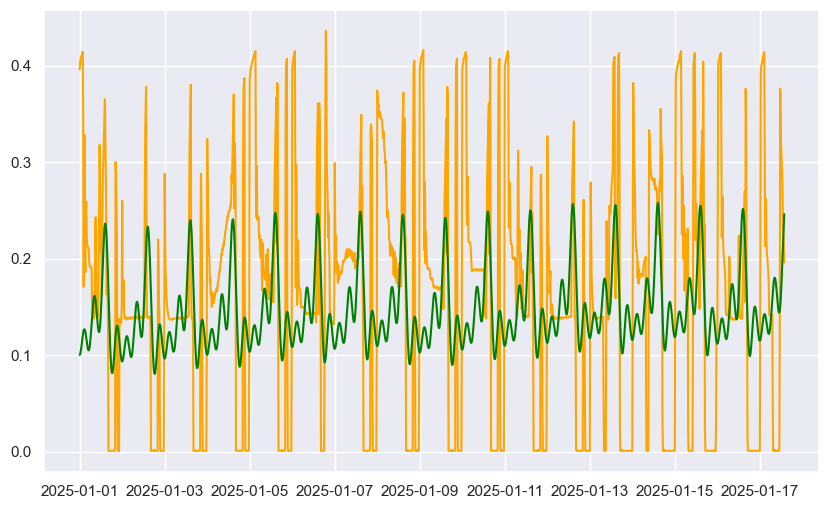

In [63]:
# Visaliseren van de voorspelling ten opzichte van de testset
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Test Data', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.show()

In [64]:
from sklearn.metrics import r2_score

r2 = r2_score(test['y'], forecast['yhat'])
print(f"R²-score: {r2:.4f}")

R²-score: 0.0631
